<a href="https://colab.research.google.com/github/solo-coder13/computational-Linguistics-Project/blob/main/Emotion_dataset_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [27]:
val_data = pd.read_csv('/content/validation.csv')
train_data = pd.read_csv('/content/training.csv')
test_data = pd.read_csv('/content/test.csv')

In [28]:
print("Validation data :",val_data.shape)
print("Train data :",train_data.shape)
print("Test data :",test_data.shape)

Validation data : (2000, 2)
Train data : (16000, 2)
Test data : (2000, 2)


In [29]:
half_test_data = test_data.iloc[1000:]
test_data = test_data.iloc[:1000]

val_data = pd.concat([val_data, half_test_data], axis=0)

print("new Vald data :",val_data.shape)
print("new Test data :",test_data.shape)

new Vald data : (3000, 2)
new Test data : (1000, 2)


In [30]:
train_data.head(10)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


In [31]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train_data['label_name'] = train_data['label'].map(labels_dict)
train_data.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [32]:
train_data.groupby(["label_name","label"]).size()

label_name  label
anger       3        2159
fear        4        1937
joy         1        5362
love        2        1304
sadness     0        4666
surprise    5         572
dtype: int64

<Axes: xlabel='label_name'>

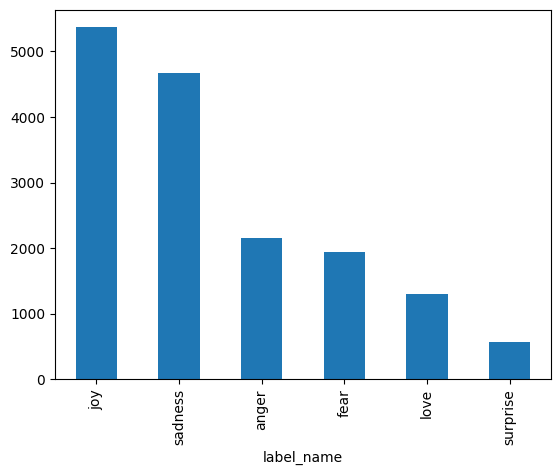

In [33]:
train_data["label_name"].value_counts().plot(kind='bar')

In [34]:
print(train_data.isnull().sum())
print(val_data.isnull().sum())
print(test_data.isnull().sum())

text          0
label         0
label_name    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


In [35]:
all_list = train_data['text'].tolist() + test_data['text'].tolist() + val_data['text'].tolist()

In [36]:
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(all_list)
word_index1 = tokenizer1.word_index

print("Nombre of words without Stemming:",len(word_index1))

stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(word) for word in word_index1.keys()]

tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(stemmed_words)
word_index2 = tokenizer2.word_index

print("Nombre of words with Stemming:",len(word_index2))

Nombre of words without Stemming: 17096
Nombre of words with Stemming: 11705


In [37]:
def preprocess_data(data):
    new_data = []
    for index, row in data.iterrows():
        test_split = row['text'].split()
        stemmed_words2 = [stemmer.stem(word) for word in test_split]
        token_list= tokenizer2.texts_to_sequences([stemmed_words2])[0]
        new_data.append([token_list,row['label']])
    return new_data

In [38]:
new_train_data = preprocess_data(train_data)
print(train_data['text'][0])
print(new_train_data[0])

i didnt feel humiliated
[[3198, 3265, 220, 665], 0]


In [39]:
new_val_data = preprocess_data(val_data)
print(val_data['text'][0])
print(new_val_data[0])

im feeling quite sad and sorry for myself but ill snap out of it soon
[[3205, 220, 595, 1335, 3199, 3326, 3206, 3227, 3207, 1326, 518, 1283, 1274, 1276, 3380], 0]


In [40]:
train_X = [row[0] for row in new_train_data]
train_y = [row[1] for row in new_train_data]

# Print the results
print("train_X:", train_X[0])
print("train_y:", train_y[0])

train_X: [3198, 3265, 220, 665]
train_y: 0


In [41]:
val_X = [row[0] for row in new_val_data]
val_y = [row[1] for row in new_val_data]

print("train_X:", val_X[0])
print("train_y:", val_y[0])

train_X: [3205, 220, 595, 1335, 3199, 3326, 3206, 3227, 3207, 1326, 518, 1283, 1274, 1276, 3380]
train_y: 0


In [42]:
length_of_longest_sentence = len(max(train_X, key=len))
print(length_of_longest_sentence)
print(max(train_X, key=len))

66
[3198, 613, 3250, 3588, 3217, 3204, 3198, 927, 3245, 1497, 3245, 1354, 3217, 3245, 1303, 1296, 3200, 2107, 1284, 1276, 3220, 220, 3598, 3213, 220, 1276, 3528, 3217, 7890, 4263, 3221, 5569, 1552, 3243, 3198, 4263, 3221, 1552, 5570, 5570, 3198, 3579, 5569, 3198, 7891, 1276, 3200, 3202, 1293, 3219, 1401, 3948, 3598, 3213, 3223, 239, 3528, 3213, 85, 3267, 579, 1658, 3206, 3201, 239, 1289]


In [43]:
for i in range(len(train_X)):
    for j in range(length_of_longest_sentence-len(train_X[i])):
        train_X[i].append(0)

for i in range(len(val_X)):
    for j in range(length_of_longest_sentence-len(val_X[i])):
        val_X[i].append(0)

In [44]:
train_X = np.array(train_X)
train_y = np.array(train_y)
val_X = np.array(val_X)
val_y = np.array(val_y)

print(train_X.shape,train_y.shape)
print(val_X.shape,val_y.shape)

(16000, 66) (16000,)
(3000, 66) (3000,)


In [45]:
train_y_one_hot = to_categorical(train_y, num_classes=16000)
val_y_one_hot = to_categorical(val_y, num_classes=16000)

In [ ]:
model = Sequential()
model.add(Embedding(16000, 100, input_length=66))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(16000, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(train_X, train_y_one_hot, epochs=25, verbose=1,validation_data=(val_X,val_y_one_hot))
#print model.summary()
print(model)

Epoch 1/25
500/500 [==============================] - 34s 52ms/step - loss: 1.8313 - accuracy: 0.3204 - val_loss: 1.6041 - val_accuracy: 0.3540
Epoch 2/25
267/500 [===============>..............] - ETA: 4s - loss: 1.6029 - accuracy: 0.3202

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
def get_text(text):
    tokenizer3 = Tokenizer()
    tokenizer3.fit_on_texts(text)
    word_index3 = tokenizer3.word_index

    stemmed_wordss = [stemmer.stem(word) for word in word_index3.keys()]

    tokens_list = tokenizer2.texts_to_sequences([stemmed_wordss])[0]

    for i in range(len(tokens_list)):
        for j in range(length_of_longest_sentence - len(tokens_list)):
            tokens_list.append(0)
    return tokens_list

user_input = input("Enter text for prediction: ")

user_test = get_text([user_input])

user_test = np.array(user_test)
user_test = user_test.reshape(1, len(user_test))

user_predictions = model.predict(user_test)

predicted_class = np.argmax(user_predictions)

print("\nPredicted Class:", predicted_class, labels_dict.get(predicted_class))